# Notebook to generate figures used in the paper

Generate image of Einstein ring and Anomalies, Probability density functions of anomalies power spectrum,
results of inference on border GRF cases, analysis of degeneracies and analysis of bias as well as of confidence intervals width.

__Notebook author__: @egorssed

__Herculens authors__: @austinpeel, @aymgal

__last updated__: 3/03/22

In [3]:
#Notebook's settings
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
Folder='/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/'
sys.path.append(Folder)

# Basic imports
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import math
from functools import partial
import time
from tqdm import tqdm

#JAX
import jax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

# Class that handles generation of GRF
from GRF_perturbations.Modules.GRF_inhomogeneities_class import GRF_inhomogeneities_class
# Class that handles all the inference related procedures
from GRF_perturbations.Modules.Surface_Brightness_class import Surface_brightness_class
# Class that handles all the inference related procedures
from GRF_perturbations.Modules.Inference_class import Inference_class
# Functions to study results of Spectra_grid estimation
from GRF_perturbations.Modules.Spectra_grid_processing import compute_SNR_grid,Infer_GRF,plot_Inference_results


#CPUs parallelization
import multiprocessing
max_thread_numbers=multiprocessing.cpu_count()
import os
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=%d"%(max_thread_numbers)

#Fontsize
FS=18

/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/jax/_src/lib/__init__.py:31: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "


# Simulation setup

## Observation conditions and spatial resolution

In [4]:
#Observation conditions
PSF_FWHM=0.1 #arcsec, PSF of HST
exposure_time=2028 #COSMOS exposure time for Poisson noise
SNR=200 #75th percentile of COSMOS dataset's distribution of Peak-SNR for Background noise

pixel_number=100 #The image is 100x100 pixels
pixel_scale=0.08 #The resolution is 0.08 arcsec/pixel
Phase_seeds_number=100  # number of random seeds that would ensure statistical significance of estimated spectrum mean and uncertainties

## Unperturbed Source-lens setup and generation/inference-related classes

In [5]:
# GRF generating class
GRF_class = GRF_inhomogeneities_class(pixel_number, pixel_scale, Phase_seeds_number)
# All the unperturbed source-lens parameters are encoded in the class as defaults
Surface_brightness = Surface_brightness_class(pixel_number, pixel_scale, PSF_FWHM, SNR, exposure_time)
# Handling all the inference-related procedures
Inference=Inference_class(GRF_class,Surface_brightness,Grad_descent_max_iter=1000) # Set 1000 steps of source-lens fitting gradient descent

del GRF_inhomogeneities_class;del Surface_brightness_class; del Inference_class

## Precomputed Anomalies spectra grid

In [6]:
grid_size=128 # resolution of logA,Beta axes
logA_array=np.linspace(-10.075,-6.9,grid_size)
Beta_array=np.linspace(0,4.7,grid_size)
Phase_seeds_number=100 # number of random seeds that would ensure statistical significance of estimated spectrum mean and uncertainties

#The grid computed for the unperturbed Source-Lens setup used in this notebook
Spectra_grid=np.load('../Processing_scripts/results/Spectra_grid.npz')['arr_0']

# Statistics of the noise
Estimated_Noise_spectral_density=(Surface_brightness.noise_var*Surface_brightness.annulus_mask).sum()/Surface_brightness.annulus_mask.sum()
#Map of SNRs for all the A,beta combinations
SNR_grid=compute_SNR_grid(Spectra_grid,Estimated_Noise_spectral_density)

/Users/egordanilov/Desktop/Lesta_shared/GRF_strong_lensing/jax-strong-lensing/GRF_perturbations/Modules/Spectra_grid_processing.py:26: RuntimeWarning: invalid value encountered in log10
  SNR=10*np.log10(np.mean(Spectra_grid-Noise_spectral_density,axis=-1)/Noise_spectral_density)


# Einstein ring Surface brightness and Anomalies

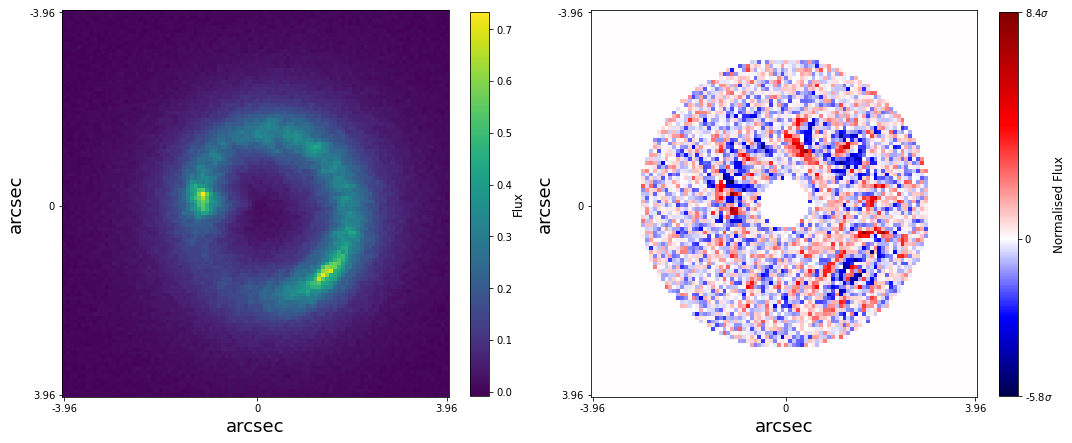

In [5]:
GRF_params=[-7.6,2.]
GRF_seed_index=2
ra_at_xy_0,dec_at_xy_0=Surface_brightness.pixel_grid.radec_at_xy_0

GRF_potential=GRF_class.potential(GRF_params,GRF_class.tensor_unit_Fourier_images[GRF_seed_index])

noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(GRF_seed_index+1)*1e+5)).astype(int)

simulate_perturbed_image=Surface_brightness.perturbed_image_getter
simulated_image=simulate_perturbed_image(GRF_potential,Noise_flag=True,noise_seed=noise_seed)

simulate_unperturbed_image=Surface_brightness.unperturbed_image_getter
Image_unperturbed_noiseless=simulate_unperturbed_image(Surface_brightness.kwargs_unperturbed_model,Noise_flag=False)

normalised_masked_residuals=((simulated_image-Image_unperturbed_noiseless)*Surface_brightness.annulus_mask)/np.sqrt(Surface_brightness.noise_var)
colorborders=[math.ceil(normalised_masked_residuals.min()*1e+1)/1e+1,0,math.floor(normalised_masked_residuals.max()*1e+1)/1e+1]

fig,ax=plt.subplots(1,2,figsize=(15,7))

img_arr=[]

img_arr+=[ax[0].imshow(simulated_image)]
cbar=fig.colorbar(img_arr[0],ax=ax[0],fraction=0.045)
cbar.ax.set_ylabel('Flux',rotation=90,fontsize=12,labelpad=0)

img_arr+=[ax[1].imshow(normalised_masked_residuals,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0))]
cbar=fig.colorbar(img_arr[1],ticks=[math.ceil(normalised_masked_residuals.min()*1e+2)/1e+2,0,math.floor(normalised_masked_residuals.max()*1e+2)/1e+2],fraction=0.045)
cbar.ax.set_ylabel('Normalised Flux',rotation=90,fontsize=12,labelpad=0)
cbar.ax.set_yticklabels(['{:.1f}'.format(colorborders[0])+r'$\sigma$', '0', '{:.1f}'.format(colorborders[2])+r'$\sigma$'])

titles=['Noisy image','Clear image','Noise']

for i,axis in enumerate(ax):
    #axis.set_title(titles[i],fontsize=FS)
    axis.set_xticks([0,50,100-1])
    axis.set_xticklabels([ra_at_xy_0,0,-ra_at_xy_0])
    axis.set_yticks([0,50,100-1])
    axis.set_yticklabels([ra_at_xy_0,0,-ra_at_xy_0])
    axis.set_xlabel('arcsec',fontsize=FS)
    axis.set_ylabel('arcsec',fontsize=FS)

plt.tight_layout()
plt.show()

# Probability density function of Anomalies power spectrum and Anomalies radial power spectrum

In [6]:
Anomalies_spectra=np.zeros((1000,100,51))
Radial_Anomalies_spectra=np.zeros((1000,len(Surface_brightness.frequencies)))

GRF_params=[-7,4]
simulate_perturbed_image=Surface_brightness.perturbed_image_getter
for i in tqdm(range(1000)):
    # Generat GRF potential
    unit_Fourier_image=GRF_class.sample_unit_Fourier_image(random_seed=i)
    GRF_potential=GRF_class.potential(GRF_params,unit_Fourier_image)
    # Generate Einstein rings
    noise_seed=jnp.round(jnp.abs(GRF_params[0]*(GRF_params[1]+1)*(i+1)*1e+5)).astype(int)
    simulated_image=simulate_perturbed_image(GRF_potential,Noise_flag=True,noise_seed=noise_seed)
    # Extract GRF and noise-defined anomalies
    Anomalies_image=simulated_image-Image_unperturbed_noiseless
    # properly normalised 2d spectrum
    Full_spectra=np.abs(np.fft.fft2(Anomalies_image))**2/pixel_number**2
    # Half of spectra is conjugate of the other half since the 'Anomalies_images' is real valued image
    Anomalies_spectra[i]=Full_spectra[:,:51]
    Radial_Anomalies_spectra[i]=Inference.compute_radial_spectrum(Anomalies_image)

100%|██████████| 1000/1000 [01:06<00:00, 15.06it/s]


## Full spectra

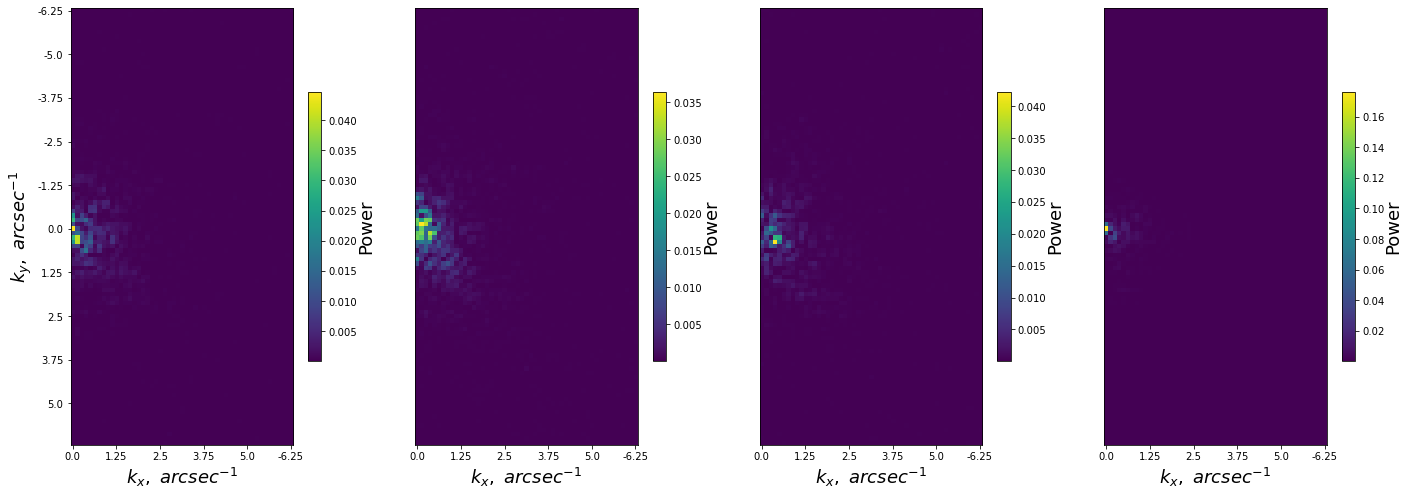

In [7]:
#1d Spatial frequencies
k_vector = np.fft.fftfreq(pixel_number, pixel_scale)
k_reduced_grid=GRF_class.k_grid[:,:51]
shifted_spectra=np.fft.fftshift(Anomalies_spectra,axes=1)

fig,ax=plt.subplots(1,4,figsize=(20,7))

for i in range(4):
    img=ax[i].imshow(shifted_spectra[i])
    ax[i].set_xticks(np.arange(0,51,10))
    ax[i].set_xticklabels((k_vector[:51])[::10])
    ax[i].set_xlabel(r'$k_x, \ arcsec^{-1}$',fontsize=FS)
    cbar=fig.colorbar(img,ax=ax[i],fraction=0.045)
    cbar.ax.set_ylabel('Power',rotation=90,fontsize=FS,labelpad=0)
    if i==0:
        ax[i].set_yticks(np.arange(0,100,10))
        ax[i].set_yticklabels(np.fft.fftshift(k_vector)[::10])
        ax[i].set_ylabel(r'$k_y, \ arcsec^{-1}$',fontsize=FS)
    else:
        ax[i].set_yticks([])

plt.tight_layout()
plt.show()

## Radial spectra

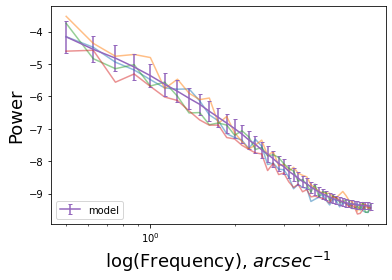

In [8]:
# Mean log(Spectrum) in the best fit log(A) and Beta
Mean_logN=np.log(Radial_Anomalies_spectra).mean(axis=-2)
# Uncertainty of log(Spectrum) in the best fit log(A) and Beta
Sigma_logN=jnp.sqrt(jnp.power(np.log(Radial_Anomalies_spectra)-Mean_logN,2).sum(axis=-2)/(len(Radial_Anomalies_spectra)-1))

for i in range(4):
    plt.plot(Surface_brightness.frequencies,np.log(Radial_Anomalies_spectra[i]),alpha=0.5)

plt.errorbar(Surface_brightness.frequencies,Mean_logN,Sigma_logN,capsize=2,alpha=1,label='model')
plt.ylabel('Power',fontsize=FS)
plt.xlabel('log(Frequency), '+r'$arcsec^{-1}$',fontsize=FS)
plt.xscale('log')
plt.legend(loc='lower left')
plt.show()

## Probability density of full spectra and radial spectra

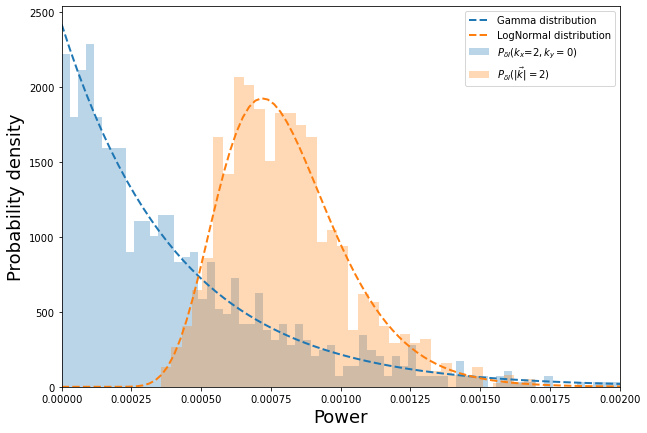

In [10]:
import scipy as sc
plt.figure(figsize=(10,7))

index_freq=16
index_rad=index_freq+1-Surface_brightness.init_freq_index

#kx=1, ky=0
plt.hist(Anomalies_spectra[:,0,index_freq],bins=100,density=True,\
         label=r'$P_{\delta I}(k_x$'+'={:.0f}'.format(Surface_brightness.frequencies[index_freq])+r'$,k_y=0)$',alpha=0.3)

single_scale=Anomalies_spectra[:,0,index_freq].mean()
x=np.linspace(0,Anomalies_spectra[:,0,index_freq].max(),100)
plt.plot(x,sc.stats.gamma.pdf(x,1,0,single_scale),label='Gamma distribution',linestyle='--',linewidth=2,color='C0')


#2<=k<2.125
#plt.hist(aggregated_spectra,bins=50,density=True,label=r'$<P_{\delta I}(|k|)>_{k \in [2,2.125)}$',color='C1',alpha=0.3)
plt.hist(Radial_Anomalies_spectra[:,index_rad],bins=50,density=True,label=r'$P_{\delta I}(|\vec{k}|=2)$',color='C1',alpha=0.3)


x=np.linspace(0,Radial_Anomalies_spectra[:,index_rad].max(),100)
plt.plot(x,sc.stats.lognorm.pdf(x,s=Sigma_logN[index_rad],loc=0,scale=np.exp(Mean_logN[index_rad])),label='LogNormal distribution',linestyle='--',linewidth=2,color='C1')



plt.xlim(0,2e-3)
plt.xlabel('Power',fontsize=FS)
plt.ylabel('Probability density',fontsize=FS)
plt.legend()
plt.show()

# Analysis of grid-based method inference results

In [11]:
def conduct_inference(GRF_params,GRF_seed_index,Inference,GRF_class):
    unit_Fourier_image=GRF_class.tensor_unit_Fourier_images[GRF_seed_index]
    # Simulate gravitational potential inhomogeneities induce by galaxy satellites
    GRF_potential=Inference.GRF_inhomogeneities.potential(GRF_params,unit_Fourier_image)

    # Jax does not tolerate randomness, but we want noise to be different for different GRFs
    noise_seed = jnp.round(jnp.abs(GRF_params[0] * (GRF_params[1] + 1) * (unit_Fourier_image[0, 1].real * 1e+3 + 1) * 1e+5)).astype(int)

    # Mock Surface brightness with noise and GRF potential perturbations
    Observed_image=Inference.simulate_perturbed_image(GRF_potential,Noise_flag=True,noise_seed=noise_seed)
    args_Unperturbed_SB=Inference.differentiable_fit_Surface_Brightness(Observed_image)
    # Surface brightness of the gravitational lens that doesn't contain GRF perturbations or noise
    Unperturbed_SB_image=Inference.simulate_unperturbed_image_pure(Inference.SL_parameters.args2kwargs(args_Unperturbed_SB))

    Observed_anomalies=Observed_image-Unperturbed_SB_image
    Anomalies_radial_spectrum=Inference.compute_radial_spectrum(Observed_anomalies)

    logA_true_index=np.argmin(np.abs(logA_array-GRF_params[0]))
    Beta_true_index=np.argmin(np.abs(Beta_array-GRF_params[1]))

    Likelihood_grid,Confidence_grid,logA_pred_index,Beta_pred_index,logA_conf_intervals,Beta_conf_intervals=Infer_GRF(Anomalies_radial_spectrum,Spectra_grid)

    return GRF_potential,Observed_image,Observed_anomalies,Likelihood_grid,Confidence_grid,logA_pred_index,Beta_pred_index,logA_true_index,Beta_true_index

In [12]:
results_low_SNR=conduct_inference([-8.7,2],1,Inference,GRF_class)
results_high_SNR=conduct_inference([-7.5,2],2,Inference,GRF_class)
results_low_Beta=conduct_inference([-8.21,0.5],0,Inference,GRF_class)
#5,9
results_high_Beta=conduct_inference([-7.3,3.5],9,Inference,GRF_class)

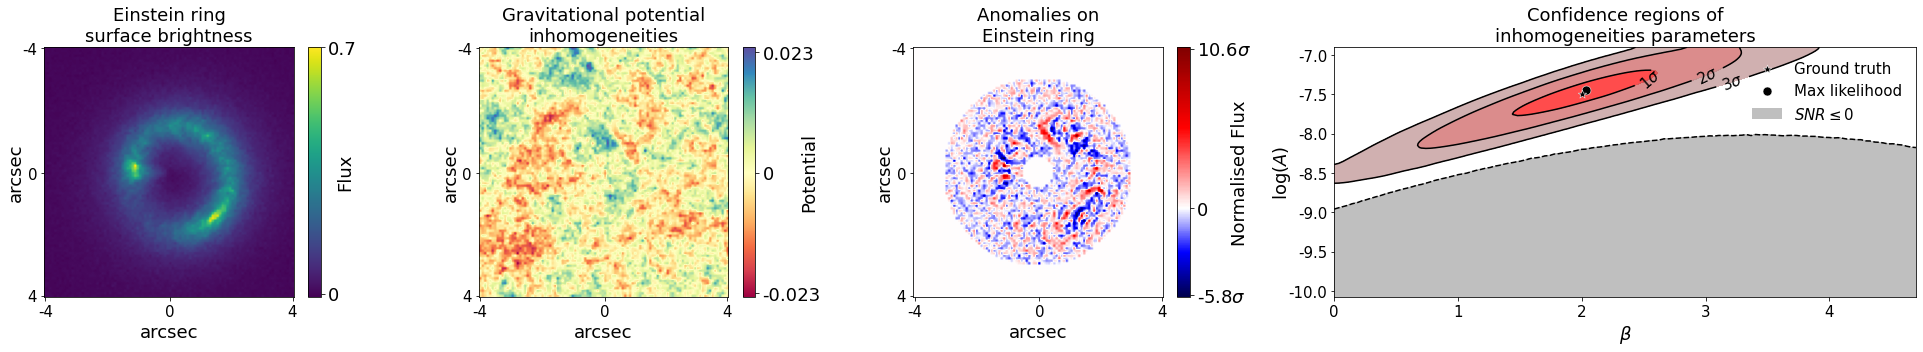

In [13]:
GRF_potential,Observed_image,Observed_anomalies,Likelihood_grid,Confidence_grid,logA_pred_index,Beta_pred_index,logA_true_index,Beta_true_index=results_high_SNR

from matplotlib import gridspec
fig=plt.figure(figsize=(27,5))
gs = gridspec.GridSpec(1, 4,
                       width_ratios=[1,1,1,2],
                       height_ratios=[1])
ax=[]
for i in range(1):
    ax_row=[]
    for j in range(4):
        axis=plt.subplot(gs[4*i+j])
        ax_row+=[axis]
    ax+=[ax_row]

ax=np.array(ax)

confidence_labels_locations=[[(4,-10)],[(4,-10)],[(4,-10)]]
plot_Inference_results(fig,ax[0],Surface_brightness,logA_array,Beta_array,Observed_image,Observed_anomalies,GRF_potential,
                       Likelihood_grid,Confidence_grid,SNR_grid,logA_true_index,Beta_true_index,confidence_labels_locations)
plt.tight_layout(h_pad=3,w_pad=2)

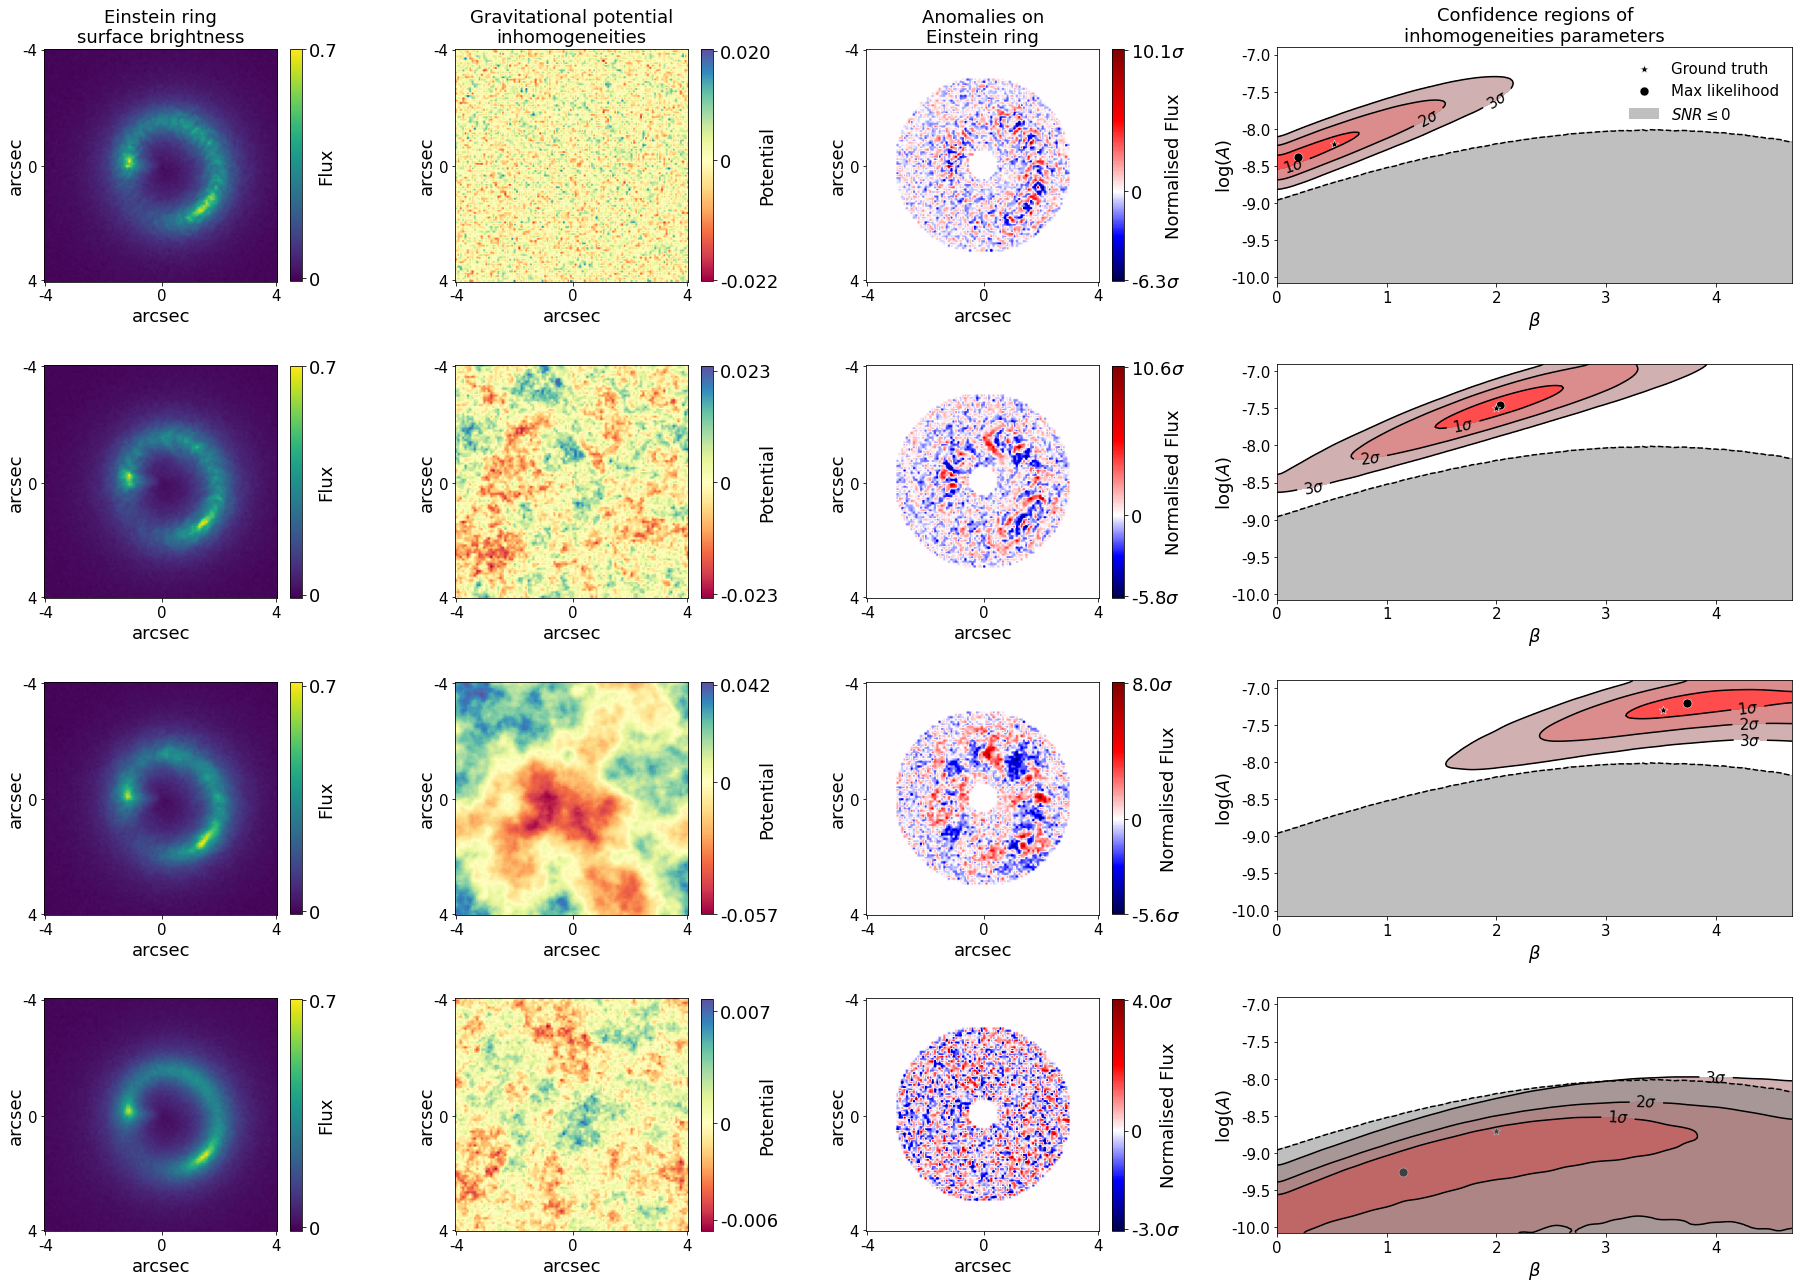

In [14]:
fig=plt.figure(figsize=(25,18))
gs = gridspec.GridSpec(4, 4,
                       width_ratios=[1,1,1,2],
                       height_ratios=[1,1,1,1])
ax=[]
for i in range(4):
    ax_row=[]
    for j in range(4):
        axis=plt.subplot(gs[4*i+j])
        ax_row+=[axis]
    ax+=[ax_row]

ax=np.array(ax)

results_array=[results_low_Beta,results_high_SNR,results_high_Beta,results_low_SNR]

#321
contour_labels_locations=[[[(5,-15)],[(4,-15)],[(0.5,-10)]],\
                         [[(1,-14)],[(1,-10)],[(2,-10)]],\
                         [[(4.3,-10)],[(4.35,-10)],[(4.5,-10)]],\
                         [[(4,-10)],[(4,10)],[(4,10)]]]

for i in range(4):
    GRF_potential,Observed_image,Observed_anomalies,Likelihood_grid,Confidence_grid,logA_pred_index,Beta_pred_index,logA_true_index,Beta_true_index=results_array[i]


    if i==0:
        titles_flag=True
        legend_flag=True
    else:
        titles_flag=False
        legend_flag=False

    plot_Inference_results(fig,ax[i],Surface_brightness,logA_array,Beta_array,Observed_image,Observed_anomalies,\
                           GRF_potential,Likelihood_grid,Confidence_grid,SNR_grid,logA_true_index,Beta_true_index,\
                           contour_labels_locations[i],logA_ind_lim=(0,128),Beta_ind_lim=(0,128),\
                           legend_flag=legend_flag,titles_flag=titles_flag)

plt.tight_layout(h_pad=3,w_pad=3)

# Eliminating degeneracy between log(A) and Beta

In [37]:
Deflection_unit_Amp_variance=np.array([GRF_class.field_variance([0.,beta],field='alpha_x')+
                                       GRF_class.field_variance([0.,beta],field='alpha_y')
                                       for beta in Beta_array])
Deflection_unit_Amp_variance_matrix,logA_matrix=np.meshgrid(Deflection_unit_Amp_variance,logA_array)
log_Deflection=np.log10(Deflection_unit_Amp_variance_matrix*np.power(10,logA_matrix))

(43.0, 128.0)

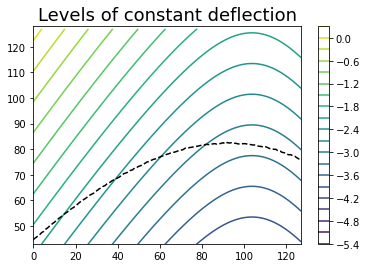

In [38]:
plt.contour(np.arange(len(Beta_array)),np.arange(len(logA_array)),log_Deflection,levels=20)
plt.colorbar()
plt.contour(np.arange(len(Beta_array)),np.arange(len(logA_array)),SNR_grid,[0],colors='k',linestyles='--')

plt.title('Levels of constant deflection',fontsize=FS)
plt.ylim(np.argmin(np.abs(logA_array-(-9))),128)

In [39]:
combined_confidence=np.ones((3,128,128))
true_coords=np.zeros((3,2))
pred_coords=np.zeros((3,2))



for i in range(3):
    _,_,_,_,Confidence_grid,logA_pred_index,Beta_pred_index,logA_true_index,Beta_true_index=results_array[i]

    #mask_1sigma=Confidence_grid<0.39347
    #confidence_1sigma=np.ones((128,128))
    #confidence_1sigma[mask_1sigma]=Confidence_grid[mask_1sigma]

    #smooth_confidence_grid=sc.ndimage.gaussian_filter(Confidence_grid,sigma=(2,2))
    combined_confidence[i]*=Confidence_grid
    true_coords[i]=[logA_true_index,Beta_true_index]
    pred_coords[i]=[logA_pred_index,Beta_pred_index]

In [40]:
#Value(A,B)->Value(alpha,B)
alpha_magrinalisation_function= lambda log_alpha: (log_alpha*2).round(1)/2

def map_from_AB_to_alphaB(Value_matrix,log_Deflection,alpha_magrinalisation_function):

    #reduced_log_Deflection=log_Deflection.round(alpha_tolerance)
    reduced_log_Deflection=alpha_magrinalisation_function(log_Deflection)


    #tensor (Value,alpha)
    Value_alphaB=np.zeros((128,128,2))
    x,y=np.meshgrid(np.arange(grid_size),np.arange(grid_size))
    #target values to map (Value,Beta)
    Value_alphaB[:,:,0]=Value_matrix[y,x]

    #alpha values
    Value_alphaB[:,:,1]=reduced_log_Deflection

    alpha_coords=np.unique(reduced_log_Deflection)
    alpha_coords.sort()
    Beta_coords=np.arange(grid_size)

    Result_matrix=np.zeros((len(alpha_coords),len(Beta_coords)))*np.nan

    for B_index in range(128):
        for i,alpha in enumerate(alpha_coords):
            #What values satisfy these coords
            Values_mask=np.where(Value_alphaB[:,B_index,1]==alpha)[0]
            #print(Values_mask)
            Values=(Value_alphaB[:,B_index,0])[Values_mask]
            Avg_Value=Values.mean()
            Result_matrix[i,B_index]=Avg_Value

    return Result_matrix

In [43]:
logDef_array=np.unique(alpha_magrinalisation_function(log_Deflection))
logDef_array.sort()

combined_confidence_logDef=np.zeros((3,len(logDef_array),len(Beta_array)))
for i in range(3):
    combined_confidence_logDef[i]=map_from_AB_to_alphaB(combined_confidence[i],log_Deflection,alpha_magrinalisation_function)

combined_confidence_logDef=np.nan_to_num(combined_confidence_logDef,nan=1)

SNR_def_matrix=map_from_AB_to_alphaB(SNR_grid,log_Deflection,alpha_magrinalisation_function)
pos_SNR=SNR_def_matrix[60:]
SNR_def_matrix[60:]=np.nan_to_num(pos_SNR,nan=np.nanmax(SNR_def_matrix))
neg_SNR=SNR_def_matrix[:60]
SNR_def_matrix[:60]=np.nan_to_num(neg_SNR,nan=np.nanmin(SNR_def_matrix))

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_35025/1184483214.py:31: RuntimeWarning: Mean of empty slice.
  Avg_Value=Values.mean()
/usr/local/Caskroom/miniforge/base/envs/env_jax/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [45]:
def plot_likelihood_custom(axis,X_array,Y_array,confidence_grid,manual_locations,fontsize=18):
    #Confidence levels
    #smooth the grid to avoid sharp edged contours
    smooth_confidence_grid=sc.ndimage.gaussian_filter(confidence_grid,sigma=(2,2))
    confidence_grid=smooth_confidence_grid

    imgConfidence=axis.contourf(X_array,Y_array,confidence_grid,[0,0.39347,0.86466,0.988891],colors=['red','indianred','rosybrown','w'],alpha=0.7)

    img=axis.contour(X_array,Y_array,confidence_grid,[0.39347,0.86466,0.988891],colors='k')

    #manual_locations=[(5,20)]
    clabel=axis.clabel(img,[0.988891],inline=True,fmt={0.988891: '$3\\sigma$'},fontsize=15,manual=manual_locations[0])
    #manual_locations=[(5,20)]
    clabel+=axis.clabel(img,[0.86466],inline=True,fmt={0.86466: '$2\\sigma$'},fontsize=15,manual=manual_locations[1])
    #manual_locations=[(5,20)]
    clabel+=axis.clabel(img,[0.39347],inline=True,fmt={0.39347: '$1\\sigma$'},fontsize=15,manual=manual_locations[2])

    for l in clabel:
        l.set_rotation(0)

    return axis,imgConfidence

Text(0, 0.5, '${\\rm log}(\\sigma^2_{\\delta \\alpha})$')

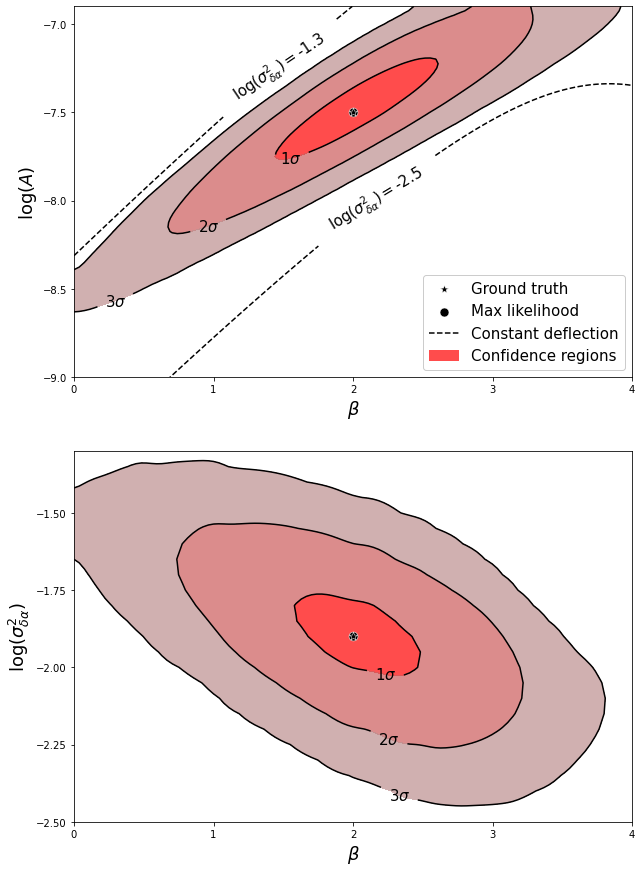

In [46]:
fig,axis=plt.subplots(2,1,figsize=(10,15))

manual_locations=[[(2.5,-17)],[(2.5,-14)],[(2,-10)]]

ax_top,imgConfidence=plot_likelihood_custom(axis[0],Beta_array,logA_array,combined_confidence[1],manual_locations)

def_lims=[-2.5,-1.3]
def_line=ax_top.contour(Beta_array,logA_array,log_Deflection,levels=def_lims,colors='k',linestyles='--')

clabel=ax_top.clabel(def_line,[def_lims[0]],inline=True,fmt={def_lims[0]: r'${\rm log}(\sigma^2_{\delta \alpha})=$'+'{:.1f}'.format(def_lims[0])},fontsize=15,manual=[(-2,-1)])
clabel=ax_top.clabel(def_line,[def_lims[1]],inline=True,fmt={def_lims[1]: r'${\rm log}(\sigma^2_{\delta \alpha})=$'+'{:.1f}'.format(def_lims[1])},fontsize=15,manual=[(-2,-2)])

true_logA_index,true_Beta_index=true_coords[1].astype(int)
pred_logA_index,pred_Beta_index=pred_coords[1].astype(int)

predPoint=ax_top.scatter(Beta_array[pred_Beta_index],logA_array[pred_logA_index],label='Max likelihood',\
                         marker="o",s=80,color='k',edgecolor='w',linewidth=0.5)
truePoint=ax_top.scatter(Beta_array[true_Beta_index],logA_array[true_logA_index],label='Ground truth',\
                         marker="*",s=80,color='k',edgecolor='w',linewidth=0.5)

ax_top.set_xticks([0,1,2,3,4])
ax_top.set_yticks([-9,-8.5,-8,-7.5,-7])

ax_top.set_ylim(-9,logA_array[-1])
ax_top.set_xlim(0,4)

ax_top.set_xlabel(r'$\beta$',fontsize=FS)
ax_top.set_ylabel(r"${\rm log}(A)$",fontsize=FS)

l=ax_top.legend([truePoint,predPoint,def_line.collections[0],plt.Rectangle((1, 1), 2, 2, fc=imgConfidence.collections[0].get_facecolor()[0]),def_line],\
                ['Ground truth','Max likelihood','Constant deflection','Confidence regions'],loc='lower right',fontsize=15,framealpha=1)
for text in l.get_texts():
    text.set_color("k")



#manual_locations=[[(1.75,-17)],[(1.8,-17)],[(2,-10)]]
manual_locations=[[(1.6,-14)],[(1.76,-10)],[(2,-10)]]
ax_bot,_=plot_likelihood_custom(axis[1],Beta_array,logDef_array,combined_confidence_logDef[1],manual_locations)


#Prediction and truth
pred_logDef_index=np.argmin(np.abs(logDef_array-log_Deflection[pred_logA_index,pred_Beta_index]))
true_logDef_index=np.argmin(np.abs(logDef_array-log_Deflection[true_logA_index,true_Beta_index]))

predPoint=ax_bot.scatter(Beta_array[pred_Beta_index],logDef_array[pred_logDef_index],label='Max likelihood',\
                         marker="o",s=80,color='k',edgecolor='w',linewidth=0.5)
truePoint=ax_bot.scatter(Beta_array[true_Beta_index],logDef_array[true_logDef_index],label='Ground truth',\
                         marker="*",s=80,color='k',edgecolor='w',linewidth=0.5)

ax_bot.set_xticks([0,1,2,3,4])
ax_bot.set_yticks([-2.5,-2.25,-2,-1.75,-1.5])

ax_bot.set_ylim(def_lims[0],def_lims[1])
ax_bot.set_xlim(0,4)

ax_bot.set_xlabel(r'$\beta$',fontsize=FS)
ax_bot.set_ylabel(r'${\rm log}(\sigma^2_{\delta \alpha})$',fontsize=FS)

# Analysis of grid-based inference quality: Biases and Uncertainties widths

In [16]:
Prediction_grid=np.load('../Processing_scripts/results/Predictions_grid.npz')['arr_0']

In [17]:
Prediction_grid.shape

(128, 128, 100, 7, 2)

In [18]:
predicted_indices=Prediction_grid[:,:,:,0]
logA_confidence_regions=Prediction_grid[:,:,:,1:4]
Beta_confidence_regions=Prediction_grid[:,:,:,4:]

In [19]:
predicted_bias=np.zeros((len(logA_array),len(Beta_array),100,2))

uncertainty_width=np.zeros((len(logA_array),len(Beta_array),100,2,3))


average_prediction=predicted_indices.mean(axis=-2)
for i in range(len(logA_array)):
    for j in range(len(Beta_array)):

        logA_uncertainty_width=logA_confidence_regions[i,j,:,:,1]-logA_confidence_regions[i,j,:,:,0]
        Beta_uncertainty_width=Beta_confidence_regions[i,j,:,:,1]-Beta_confidence_regions[i,j,:,:,0]

        #(sigma_top+sigma_bot)/2
        uncertainty_width[i,j,:,0,:]=logA_uncertainty_width/2
        uncertainty_width[i,j,:,1,:]=Beta_uncertainty_width/2

        predicted_bias[i,j,:,0]=(predicted_indices[i,j,:,0]-i)
        predicted_bias[i,j,:,1]=(predicted_indices[i,j,:,1]-j)


mean_bias=(predicted_bias/uncertainty_width[:,:,:,:,0]).mean(axis=-2)
std_bias=(predicted_bias/uncertainty_width[:,:,:,:,0]).std(axis=-2)

## Bias of log(A)

In [20]:
#Bias image
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
import scipy as sc
#Bias image
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch

def make_legend_arrow(legend, orig_handle,
                      xdescent, ydescent,
                      width, height, fontsize):
    p = mpatches.FancyArrow(width, 0.5*height, -width, 0, length_includes_head=True, head_width=0.75*height )
    return p

red_patch = mpatches.Patch(color='red', label='The red data')

def make_logA_bias_figure(axis,mean_bias,img_arr,manual_locations,limit_amplitude=-9,\
                     clabel_fontsize=10,labels_fontsize=10,inline_spacing=70,linewidths=5,\
                     quiver_kwargs={'scale':20,'width':0.0015,'headwidth':7,'headlength':7.5,'pivot':'middle'}):

    logA_bias=mean_bias[:,:,0]

    #arrow_color=mpl.cm.get_cmap('k')(0)
    arrow_color='k'
    imgarr=axis.arrow(12,95-5,0,7,head_width=2,color=arrow_color,alpha=1)
    axis.arrow(116,95+5,0,-7,head_width=2,color=arrow_color,alpha=1)




    #Bias background image
    img_arr+=[axis.imshow(logA_bias,cmap='coolwarm',norm=mpl.colors.TwoSlopeNorm(0,-1,logA_bias.max()),alpha=1,label='Bias amplitude')]

    clabels=[]
    #SNR contour
    imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=1,labels='SNR=0')
    clabels+=axis.clabel(imgSNR,[0],inline=True,fmt={0: 'SNR=0'},\
                             fontsize=clabel_fontsize,manual=manual_locations[0],inline_spacing=inline_spacing)

    for i,l in enumerate(clabels):
        clabels[i].set_rotation(0)


    #Legend
    yellow_patch = mpatches.Patch(color=mpl.cm.get_cmap('coolwarm')(0.75))
    axis.legend([yellow_patch,imgarr,imgSNR.collections[0]], ['Bias amplitude','Bias direction','SNR=0'], \
    handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow),},\
          loc='lower right',framealpha=1,facecolor='w',labelcolor='k')

    labelstep=15



    #Y axis
    axis.invert_yaxis()


    yticks=np.array([np.argmin(np.abs(logA_array-x)) for x in [-9,-8.5,-8,-7.5,-7]])
    yticklabels=[-9.0,-8.5,-8.0,-7.5,-7.0]
    axis.set_yticks(yticks)
    axis.set_yticklabels(yticklabels)
    axis.set_ylabel('log(A)',fontsize=labels_fontsize)


    #X axis
    xticks=np.array([np.argmin(np.abs(Beta_array-x)) for x in [0,1,2,3,4]])
    xticklabels=[0,1,2,3,4]
    axis.set_xticks(xticks)
    axis.set_xticklabels(xticklabels)

    #axis.set_xticks(np.arange(0,len(Beta_array),labelstep))
    #axis.set_xticklabels(Beta_array[::labelstep].round(1),rotation=90)
    axis.set_xlabel(r'$\beta$',fontsize=labels_fontsize)


    #Title and colorbar
    axis.set_title('log(A) bias',fontsize=labels_fontsize)
    cbar=plt.colorbar(img_arr[-1],ax=axis,fraction=0.03,ticks=[-1,-0.5,0,0.5,1],extend='min')
    cbar.ax.set_ylabel('Normalised error',rotation=90,fontsize=labels_fontsize,labelpad=5)
    cbar.ax.set_yticklabels([r'$-1 \sigma$',r'$-0.5\sigma$','0',r'$0.5\sigma$',r'$1 \sigma$'])


    axis.set_ylim(np.argmin(np.abs(logA_array-(-9))),128)


    return img_arr

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_35742/3201361436.py:36: UserWarning: The following kwargs were not used by contour: 'labels'
  imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=1,labels='SNR=0')


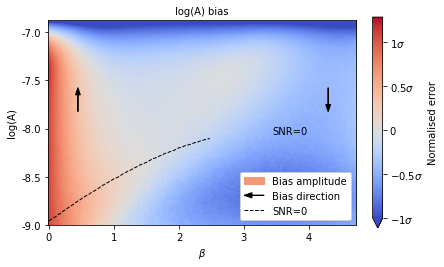

In [22]:
fig,axis=plt.subplots(1,1)
manual_locations=[[(100,100)],[(90,60)]]
img_arr=[]
img_arr=make_logA_bias_figure(axis,mean_bias,img_arr,manual_locations)

## Bias of $\beta$

In [24]:
def make_Beta_bias_figure(axis,mean_bias,img_arr,manual_locations,limit_amplitude=-9,\
                     clabel_fontsize=10,labels_fontsize=10,inline_spacing=70,linewidths=5,\
                     quiver_kwargs={'scale':20,'width':0.0015,'headwidth':7,'headlength':7.5,'pivot':'middle'}):

    Beta_bias=mean_bias[:,:,1]

    #arrow_color=mpl.cm.get_cmap('k')(0)
    arrow_color='k'
    imgarr=axis.arrow(12-5,95,7,0,head_width=2,color=arrow_color,alpha=1)
    axis.arrow(116+5,95,-7,0,head_width=2,color=arrow_color,alpha=1)




    #Bias background image
    img_arr+=[axis.imshow(Beta_bias,cmap='coolwarm',norm=mpl.colors.TwoSlopeNorm(0,Beta_bias.min(),1),alpha=1,label='Bias amplitude')]

    clabels=[]
    #SNR contour
    imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=1,labels='SNR=0')
    clabels+=axis.clabel(imgSNR,[0],inline=True,fmt={0: 'SNR=0'},\
                             fontsize=clabel_fontsize,manual=manual_locations[0],inline_spacing=inline_spacing)

    for i,l in enumerate(clabels):
        clabels[i].set_rotation(0)


    #Legend
    yellow_patch = mpatches.Patch(color=mpl.cm.get_cmap('coolwarm')(0.75))
    axis.legend([yellow_patch,imgarr,imgSNR.collections[0]], ['Bias amplitude','Bias direction','SNR=0'], \
    handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow),},\
          loc='lower right',framealpha=1,facecolor='w',labelcolor='k')

    labelstep=15
    #Y axis
    axis.invert_yaxis()

    axis.set_yticks([])
    '''
    yticks=np.array([np.argmin(np.abs(logA_array-x)) for x in [-9,-8.5,-8,-7.5,-7]])
    yticklabels=[-9.0,-8.5,-8.0,-7.5,-7.0]
    axis.set_yticks(yticks)
    axis.set_yticklabels(yticklabels)
    axis.set_ylabel('log(A)',fontsize=labels_fontsize)
    '''

    #X axis
    xticks=np.array([np.argmin(np.abs(Beta_array-x)) for x in [0,1,2,3,4]])
    xticklabels=[0,1,2,3,4]
    axis.set_xticks(xticks)
    axis.set_xticklabels(xticklabels)

    #axis.set_xticks(np.arange(0,len(Beta_array),labelstep))
    #axis.set_xticklabels(Beta_array[::labelstep].round(1),rotation=90)
    axis.set_xlabel(r'$\beta$',fontsize=labels_fontsize)


    #Title and colorbar
    axis.set_title(r'$\beta$'+' bias',fontsize=labels_fontsize)
    cbar=plt.colorbar(img_arr[-1],ax=axis,ticks=[-1,-0.5,0,0.5,1],fraction=0.03,extend='max')
    cbar.ax.set_ylabel('Normalised error',rotation=90,fontsize=labels_fontsize,labelpad=5)
    cbar.ax.set_yticklabels([r'$-1 \sigma$',r'$-0.5\sigma$','0',r'$0.5\sigma$',r'$1 \sigma$'])


    axis.set_ylim(np.argmin(np.abs(logA_array-(-9))),128)

    return img_arr

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_35742/3814155029.py:20: UserWarning: The following kwargs were not used by contour: 'labels'
  imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=1,labels='SNR=0')


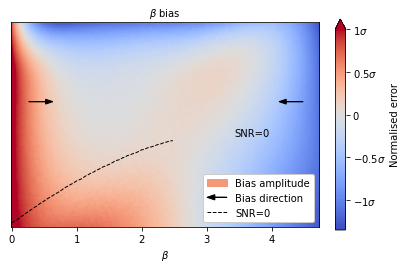

In [25]:
fig,axis=plt.subplots(1,1)

img_arr=[]
img_arr=make_Beta_bias_figure(axis,mean_bias,img_arr,manual_locations)

## Vector-like bias representation

In [33]:
#Bias image
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerPatch
import scipy as sc

def make_legend_arrow(legend, orig_handle,
                      xdescent, ydescent,
                      width, height, fontsize):
    p = mpatches.FancyArrow(width, 0.5*height, -width, 0, length_includes_head=True, head_width=0.75*height )
    return p

'''
#imgCont=axis.contour(X,Y,smooth_amplitude,[0.25,0.5,1],colors='k',linewidths=linewidths)


    #Quiver
    complex_vector=(mean_bias[:,:,1]+1j*mean_bias[:,:,0])
    angle=np.angle(complex_vector)

    amp=mean_bias_normalised_amp
    I_quiver=np.cos(angle)*amp
    J_quiver=np.sin(angle)*amp

    imgarr=axis.arrow(0,0,0,0,color=arrow_color,alpha=1)

    I_quiver=sc.ndimage.gaussian_filter(I_quiver,sigma=(quiver_step,quiver_step),mode='mirror')
    J_quiver=sc.ndimage.gaussian_filter(J_quiver,sigma=(quiver_step,quiver_step),mode='mirror')

    quiver_index=np.append(np.arange(0,128,quiver_step),[126])
    X,Y=np.meshgrid(quiver_index,quiver_index)

    #scale=20,width=0.0015,headwidth=7,headlength=7.5,pivot='middle'
    imgquiver=axis.quiver(X,Y,I_quiver[Y,X], J_quiver[Y,X],label='Bias direction',color=arrow_color,**quiver_kwargs)
'''
def make_bias_figure(axis,mean_bias,img_arr,manual_locations,limit_bias=1,limit_quiver=0.5,limit_amplitude=-9,\
                     clabel_fontsize=10,labels_fontsize=10,inline_spacing=70,linewidths=5,\
                     quiver_kwargs={'scale':20,'width':0.0015,'headwidth':7,'headlength':7.5,'pivot':'middle'}):

    I=mean_bias[:,:,1]
    J=mean_bias[:,:,0]
    Bias_amplitude=np.sqrt(I**2+J**2)
    Bias_amplitude[Bias_amplitude>limit_bias]=limit_bias

    arrow_color=mpl.cm.get_cmap('magma_r')(0)
    imgarr=axis.arrow(0,0,0,0,color=arrow_color,alpha=1)


    #Bias background image
    #img_arr+=[axis.imshow(Bias_amplitude,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(0),alpha=1,label='Bias amplitude')]
    img_arr+=[axis.imshow(Bias_amplitude,cmap='magma_r',alpha=1,label='Bias amplitude')]


    #Contours of bias
    smooth_amplitude=sc.ndimage.gaussian_filter(Bias_amplitude,1,mode='constant')
    imgCont=axis.contour(X,Y,smooth_amplitude,[0.25,0.5,1],colors='k',linewidths=linewidths)
    #imgCont=axis.contour(X,Y,smooth_amplitude,[0.25,0.5,1],colors='w',linewidths=linewidths)



    #manual_locations=[(5,20)]
    clabels=axis.clabel(imgCont,[0.5],inline=True,fmt={0.5: '$0.5\\sigma$'},fontsize=clabel_fontsize,manual=manual_locations[0],inline_spacing=inline_spacing)
    clabels+=axis.clabel(imgCont,[0.25],inline=True,fmt={0.25: '$0.25\\sigma$'},fontsize=clabel_fontsize,manual=manual_locations[1],inline_spacing=inline_spacing)

    for i,l in enumerate(clabels):
        clabels[i].set_rotation(0)

    #Quiver
    step=20
    mask_quiver=Bias_amplitude>limit_quiver
    I_quiver=mask_quiver*I
    J_quiver=mask_quiver*J
    #scale=20,width=0.0015,headwidth=7,headlength=7.5,pivot='middle'

    imgquiver=axis.quiver(X[::step,::step],Y[::step,::step],I_quiver[::step,::step], J_quiver[::step,::step],label='Bias direction',color=arrow_color,**quiver_kwargs)



    #SNR contour
    #imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--')
    #imgSNR=axis.contourf(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[SNR_grid.min(),0],colors='grey',alpha=0.5)

    #Legend
    yellow_patch = mpatches.Patch(color=arrow_color)
    axis.legend([yellow_patch,imgarr], ['Bias amplitude','Bias direction'], \
    handler_map={mpatches.FancyArrow : HandlerPatch(patch_func=make_legend_arrow),},\
          loc='lower right',framealpha=1,facecolor='k',labelcolor='w')


    labelstep=15
    #Y axis
    axis.invert_yaxis()

    axis.set_yticks(np.arange(0,len(logA_array),labelstep))
    axis.set_yticklabels(logA_array[::labelstep].round(1))
    axis.set_ylabel('log(A)',fontsize=labels_fontsize)

    axis.set_ylim(np.argmin(np.abs(logA_array-(limit_amplitude))),128)

    #X axis
    axis.set_xticks(np.arange(0,len(Beta_array),labelstep))
    axis.set_xticklabels(Beta_array[::labelstep].round(1),rotation=90)
    axis.set_xlabel(r'$\beta$',fontsize=labels_fontsize)


    #Title and colorbar
    axis.set_title('Bias',fontsize=labels_fontsize)
    cbar=plt.colorbar(img_arr[-1],ax=axis,ticks=[0,0.25,0.5,0.75,1],fraction=0.03)
    cbar.ax.set_ylabel('Normalised error',rotation=90,fontsize=labels_fontsize,labelpad=5)
    cbar.ax.set_yticklabels(['0',r'$0.25\sigma$',r'$0.5\sigma$',r'$0.75\sigma$',r'$1 \sigma$'])

    return img_arr

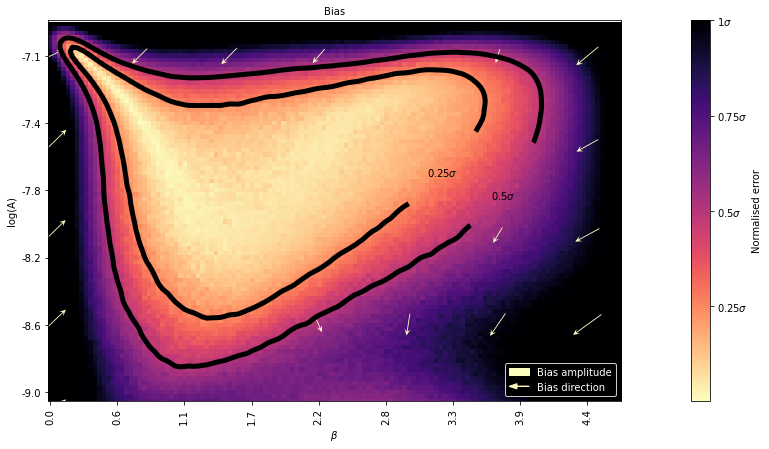

In [35]:
I=mean_bias[:,:,1]
J=mean_bias[:,:,0]

X,Y=np.meshgrid(np.arange(len(Beta_array)),np.arange(len(logA_array)))

images=[np.sqrt(I**2+J**2),std_bias[:,:,0],std_bias[:,:,1]]
titles=[r'$\mu$',r'$\sigma_{logA}$',r'$\sigma_{\beta}$']

fig,ax=plt.subplots(1,1,figsize=(25,7))

img_arr=[]
manual_locations=[[(100,100)],[(90,60)]]
img_arr=make_bias_figure(ax,mean_bias,img_arr,manual_locations,limit_bias=1,
                         quiver_kwargs={'scale':20,'width':0.0015,'headwidth':7,'headlength':7.5,'pivot':'mid'})

## Uncertainty of log(A)

In [26]:
from matplotlib.legend_handler import HandlerTuple
from skimage import measure
def make_logA_uncertainty_figure(axis,uncertainty_width,img_arr,manual_locations,limit_uncertainty=0.6,limit_amplitude=-9,\
                                 clabel_fontsize=10,labels_fontsize=10,inline_spacing=70,linewidths=1):

    sigma=1
    Uncertainty=uncertainty_width.mean(axis=2)[:,:,0,sigma-1]*(logA_array[1]-logA_array[0])
    Uncertainty[Uncertainty>limit_uncertainty]=limit_uncertainty


    Zero_SNR_indices=measure.find_contours(SNR_grid,0)[0]
    Zero_SNR_indices=np.array(Zero_SNR_indices).round().astype(int).T
    Zero_SNR_uncertainty=Uncertainty[Zero_SNR_indices[0],Zero_SNR_indices[1]].max()
    #Uncertainty image
    img_arr+=[axis.imshow(Uncertainty,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(Zero_SNR_uncertainty,0.2),alpha=0.75)]

    #Contours of uncert
    smooth_amplitude=sc.ndimage.gaussian_filter(Uncertainty,1,mode='constant')
    smooth_amplitude[:,-2:]=Uncertainty[:,-2:]
    smooth_amplitude[:,:2]=Uncertainty[:,:2]
    '''
    imgCont=axis.contour(X,Y,smooth_amplitude,[0.25,0.3,0.35],colors='k',linewidths=linewidths)

    clabels=axis.clabel(imgCont,[0.35],inline=True,fmt={0.35: '$\\sigma=0.35$'},\
                        fontsize=clabel_fontsize,manual=manual_locations[0],inline_spacing=inline_spacing)
    clabels+=axis.clabel(imgCont,[0.3],inline=True,fmt={0.3: '$\\sigma=0.3$'},\
                fontsize=clabel_fontsize,manual=manual_locations[1],inline_spacing=inline_spacing)
    clabels+=axis.clabel(imgCont,[0.25],inline=True,fmt={0.25: '$\\sigma=0.25$'},\
                fontsize=clabel_fontsize,manual=manual_locations[2],inline_spacing=inline_spacing)
    '''
    clabels=[]
    #SNR contour
    imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=linewidths,labels='SNR=0')
    clabels+=axis.clabel(imgSNR,[0],inline=True,fmt={0: 'SNR=0'},\
                         fontsize=clabel_fontsize,manual=manual_locations[3],inline_spacing=inline_spacing)

    for i,l in enumerate(clabels):
        clabels[i].set_rotation(0)

    labelstep=15
    #Y axis
    axis.invert_yaxis()

    axis.set_ylim(np.argmin(np.abs(logA_array-(limit_amplitude))),128)

    yticks=np.array([np.argmin(np.abs(logA_array-x)) for x in [-9,-8.5,-8,-7.5,-7]])
    yticklabels=[-9.0,-8.5,-8.0,-7.5,-7.0]
    axis.set_yticks(yticks)
    axis.set_yticklabels(yticklabels)
    #axis.set_yticks(np.arange(0,len(logA_array),labelstep))
    #axis.set_yticklabels(logA_array[::labelstep].round(1))
    axis.set_ylabel('log(A)',fontsize=labels_fontsize)


    #X axis
    xticks=np.array([np.argmin(np.abs(Beta_array-x)) for x in [0,1,2,3,4]])
    xticklabels=[0,1,2,3,4]
    axis.set_xticks(xticks)
    axis.set_xticklabels(xticklabels)

    #axis.set_xticks(np.arange(0,len(Beta_array),labelstep))
    #axis.set_xticklabels(Beta_array[::labelstep].round(1),rotation=90)
    axis.set_xlabel(r'$\beta$',fontsize=labels_fontsize)

    #Title and colorbar
    axis.set_title('log(A) uncertainty',fontsize=labels_fontsize)
    cbar=plt.colorbar(img_arr[-1],ax=axis,ticks=[0.25,0.35,0.45,0.6],fraction=0.03,extend='min')
    cbar.ax.set_ylabel('log(A) units',rotation=90,fontsize=labels_fontsize,labelpad=5)

    blue_patch = mpatches.Patch(color=mpl.cm.get_cmap('seismic')(0.3))
    #axis.legend([blue_patch,imgCont.collections[0],imgSNR.collections[0]], [r'$\sigma_{log(A)}$',r'$\sigma=const$','SNR=0'],loc='lower right',framealpha=1,facecolor='w')
    axis.legend([blue_patch,imgSNR.collections[0]], [r'$\sigma_{log(A)}$','SNR=0'],loc='lower right',framealpha=1,facecolor='w')



    return img_arr

/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_35742/2236807832.py:33: UserWarning: The following kwargs were not used by contour: 'labels'
  imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=linewidths,labels='SNR=0')


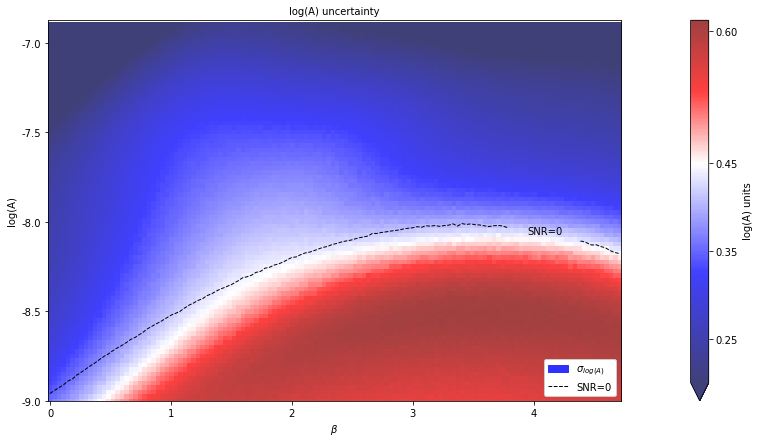

In [29]:
fig,ax=plt.subplots(1,1,figsize=(25,7))

img_arr=[]
manual_locations=[[(110,60)],[(110,60)],[(110,60)],[(110,60)]]
img_arr=make_logA_uncertainty_figure(ax,uncertainty_width,img_arr,manual_locations,limit_uncertainty=1)

## Uncertainty of $\beta$

In [30]:
def make_Beta_uncertainty_figure(axis,uncertainty_width,img_arr,manual_locations,limit_uncertainty=0.6,limit_amplitude=-9,\
                                 clabel_fontsize=10,labels_fontsize=10,inline_spacing=70,linewidths=1):

    sigma=1
    Uncertainty=uncertainty_width.mean(axis=2)[:,:,1,sigma-1]*(Beta_array[1]-Beta_array[0])
    Uncertainty[Uncertainty>limit_uncertainty]=limit_uncertainty

    Zero_SNR_indices=measure.find_contours(SNR_grid,0)[0]
    Zero_SNR_indices=np.array(Zero_SNR_indices).round().astype(int).T
    Zero_SNR_uncertainty=Uncertainty[Zero_SNR_indices[0],Zero_SNR_indices[1]].max()
    #Uncertainty image
    img_arr+=[axis.imshow(Uncertainty,cmap='seismic',norm=mpl.colors.TwoSlopeNorm(Zero_SNR_uncertainty,0.35),alpha=0.75)]

    #Contours of uncert
    smooth_amplitude=sc.ndimage.gaussian_filter(Uncertainty,1,mode='constant')
    smooth_amplitude[-2:,:]=Uncertainty[-2:,:]
    smooth_amplitude[:,-2:]=Uncertainty[:,-2:]
    smooth_amplitude[:,:2]=Uncertainty[:,:2]
    '''
    imgCont=axis.contour(X,Y,smooth_amplitude,[0.5,0.7,0.9],colors='k',linewidths=linewidths)

    clabels=axis.clabel(imgCont,[0.9],inline=True,fmt={0.9: '$\\sigma=0.9$'},\
                          fontsize=clabel_fontsize,manual=manual_locations[0],inline_spacing=inline_spacing)
    clabels+=axis.clabel(imgCont,[0.7],inline=True,fmt={0.7: '$\\sigma=0.7$'},\
                          fontsize=clabel_fontsize,manual=manual_locations[1],inline_spacing=inline_spacing)
    clabels+=axis.clabel(imgCont,[0.5],inline=True,fmt={0.5: '$\\sigma=0.5$'},\
                          fontsize=clabel_fontsize,manual=manual_locations[2],inline_spacing=inline_spacing)
    '''
    clabels=[]
    #SNR contour
    imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=linewidths)
    clabels+=axis.clabel(imgSNR,[0],inline=True,fmt={0: 'SNR=0'},\
                          fontsize=clabel_fontsize,manual=manual_locations[3],inline_spacing=inline_spacing)

    for i,l in enumerate(clabels):
        clabels[i].set_rotation(0)

    labelstep=15
    #Y axis
    axis.invert_yaxis()

    axis.set_yticks([])
    axis.set_ylim(np.argmin(np.abs(logA_array-(limit_amplitude))),128)

    '''
    yticks=np.array([np.argmin(np.abs(logA_array-x)) for x in [-9,-8.5,-8,-7.5,-7]])
    yticklabels=[-9.0,-8.5,-8.0,-7.5,-7.0]
    axis.set_yticks(yticks)
    axis.set_yticklabels(yticklabels)
    axis.set_ylabel('log(A)',fontsize=labels_fontsize)
    '''

    #X axis
    xticks=np.array([np.argmin(np.abs(Beta_array-x)) for x in [0,1,2,3,4]])
    xticklabels=[0,1,2,3,4]
    axis.set_xticks(xticks)
    axis.set_xticklabels(xticklabels)

    #axis.set_xticks(np.arange(0,len(Beta_array),labelstep))
    #axis.set_xticklabels(Beta_array[::labelstep].round(1),rotation=90)
    axis.set_xlabel(r'$\beta$',fontsize=labels_fontsize)

    #Title and colorbar
    axis.set_title(r'$\beta$'+' uncertainty',fontsize=labels_fontsize)
    cbar=plt.colorbar(img_arr[-1],ax=axis,ticks=[0.4,0.6,0.8,1,1.2,1.4],fraction=0.03,extend='min')
    cbar.ax.set_ylabel(r'$\beta$'+' units',rotation=90,fontsize=labels_fontsize,labelpad=5)


    cbar.ax.set_yticklabels(['0.4','0.6','0.8','1','1.2','1.4'])

    blue_patch = mpatches.Patch(color=mpl.cm.get_cmap('seismic')(0.3))
    #axis.legend([blue_patch,imgCont.collections[0],imgSNR.collections[0]], [r'$\sigma_{\beta}$',r'$\sigma=const$','SNR=0'],loc='lower right',framealpha=1,facecolor='w')
    axis.legend([blue_patch,imgSNR.collections[0]], [r'$\sigma_{\beta}$','SNR=0'],loc='lower right',framealpha=1,facecolor='w')

    return img_arr

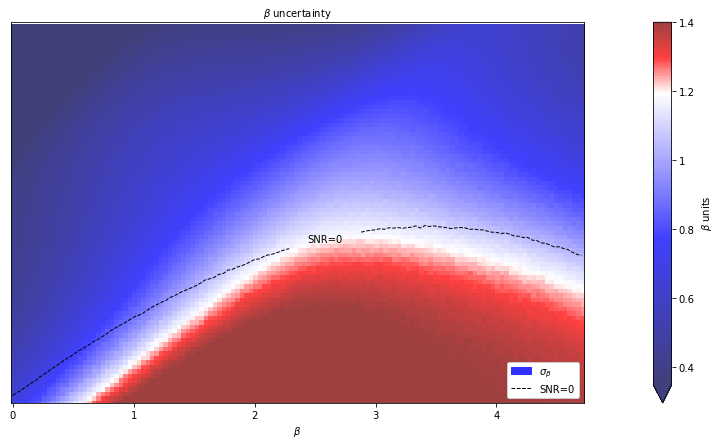

In [31]:
fig,ax=plt.subplots(1,1,figsize=(25,7))

img_arr=[]
manual_locations=[[(70,60)],[(70,60)],[(70,60)],[(70,60)]]
img_arr=make_Beta_uncertainty_figure(ax,uncertainty_width,img_arr,manual_locations,limit_uncertainty=1.4)


## Biases and Uncertainties of grid-based inference algorithm


/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_35742/3201361436.py:36: UserWarning: The following kwargs were not used by contour: 'labels'
  imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=1,labels='SNR=0')
/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_35742/3814155029.py:20: UserWarning: The following kwargs were not used by contour: 'labels'
  imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=1,labels='SNR=0')
/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_35742/2236807832.py:33: UserWarning: The following kwargs were not used by contour: 'labels'
  imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=linewidths,labels='SNR=0')


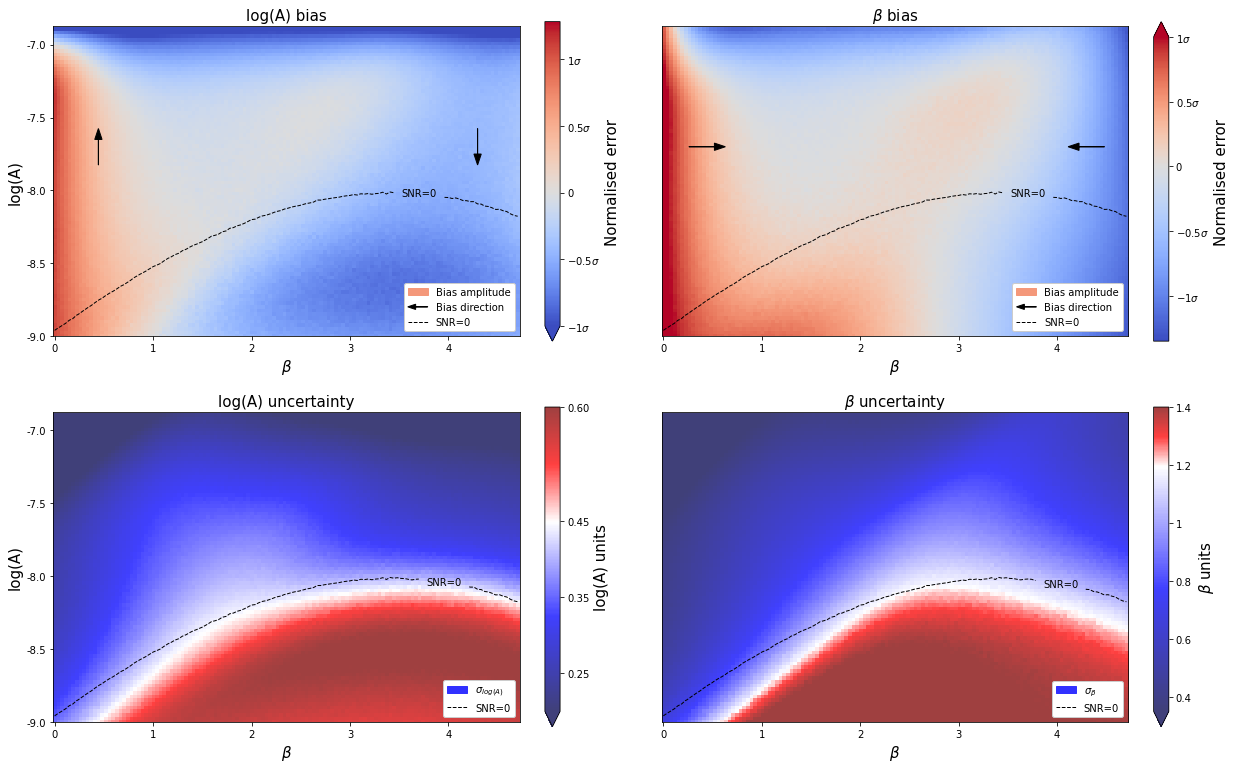

In [32]:
fig,ax=plt.subplots(2,2,figsize=(20,13))

img_arr=[]

manual_locations=[[(100,99)],[(100,90)]]
img_arr=make_logA_bias_figure(ax[0,0],mean_bias,img_arr,manual_locations,\
                         clabel_fontsize=10,labels_fontsize=15,inline_spacing=10,linewidths=1)


manual_locations=[[(100,99)],[(100,90)]]
img_arr=make_Beta_bias_figure(ax[0,1],mean_bias,img_arr,manual_locations,\
                         clabel_fontsize=10,labels_fontsize=15,inline_spacing=10,linewidths=1)

manual_locations=[[(105,60)],[(100,60)],[(90,60)],[(105,60)]]
img_arr=make_logA_uncertainty_figure(ax[1,0],uncertainty_width,img_arr,manual_locations,limit_uncertainty=0.6,\
                                     clabel_fontsize=10,labels_fontsize=15,inline_spacing=10,linewidths=1)

manual_locations=[[(107,70)],[(88,70)],[(95,80)],[(108,60)]]
img_arr=make_Beta_uncertainty_figure(ax[1,1],uncertainty_width,img_arr,manual_locations,limit_uncertainty=1.4,\
                                     clabel_fontsize=10,labels_fontsize=15,inline_spacing=10,linewidths=1)

#fig.tight_layout(w_pad=3)
plt.show()


## Vector-like bias representation and uncertainties


/var/folders/b3/rq1fyqk54w16ckpbh3g_g7tc0000gn/T/ipykernel_35742/2236807832.py:33: UserWarning: The following kwargs were not used by contour: 'labels'
  imgSNR=axis.contour(np.arange(0,len(Beta_array)),np.arange(0,len(logA_array)),SNR_grid,[0],colors='k',linestyles='--',linewidths=linewidths,labels='SNR=0')


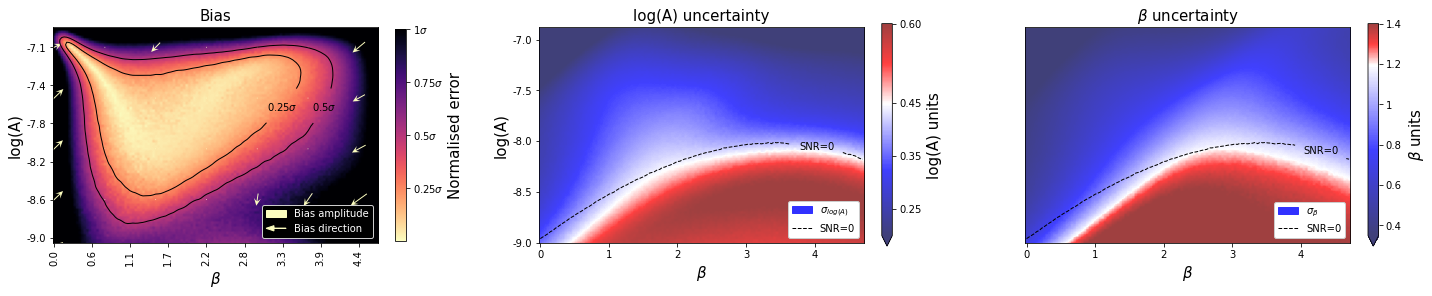

In [36]:
fig,ax=plt.subplots(1,3,figsize=(20,7))

img_arr=[]

manual_locations=[[(100,99)],[(100,90)]]
quiver_kwargs={'scale':20,'width':0.003,'headwidth':7,'headlength':7.5,'pivot':'mid'}
img_arr=make_bias_figure(ax[0],mean_bias,img_arr,manual_locations,limit_bias=1,limit_quiver=0.75,\
                         clabel_fontsize=10,labels_fontsize=15,inline_spacing=10,linewidths=1,quiver_kwargs=quiver_kwargs)

manual_locations=[[(105,60)],[(100,60)],[(90,60)],[(105,60)]]
img_arr=make_logA_uncertainty_figure(ax[1],uncertainty_width,img_arr,manual_locations,limit_uncertainty=0.6,\
                                     clabel_fontsize=10,labels_fontsize=15,inline_spacing=10,linewidths=1)

manual_locations=[[(107,70)],[(88,70)],[(95,80)],[(108,60)]]
img_arr=make_Beta_uncertainty_figure(ax[2],uncertainty_width,img_arr,manual_locations,limit_uncertainty=1.4,\
                                     clabel_fontsize=10,labels_fontsize=15,inline_spacing=10,linewidths=1)

fig.tight_layout(w_pad=3)
plt.show()
